Алгоритм нацелен на то, чтобы оставить только те Bounding boxes, которые имеют максимальное значение confidence, а остальные bounding boxes, которые имеют IoU больше treshold c этими bounding boxes, удалить. Это необходимо делать, т.к., к примеру, RPN (Region Proposal Network) на выходе (в Faster RCNN) имеет множество гипотез, и необходимо удалить лишние (с помощью NMS - Non Maximum Suppression алгоритма).

In [188]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from typing import List, Union, Literal, Tuple

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

%matplotlib inline

In [258]:
random.seed(42)

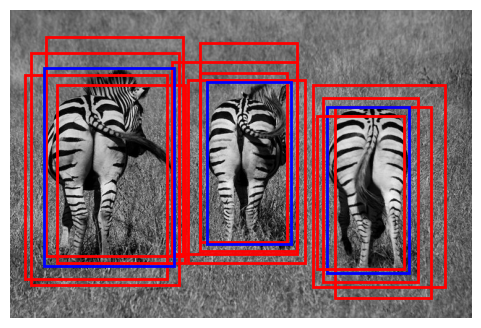

In [259]:
colors ={
    0: "blue",  # bboxes с максимальным значением confidence (после Non Max Suppression должны остаться именно они)
    1: "red",    # остальные boxes, которые должны быть удалены алгоритмом Non Max Suppression
}
img_name = "36552cec-2631046560_d08a45b9dd_z.jpg"

# загружаем изображение
img = Image.open("./data/images/%s" % img_name)
fig, ax = plt.subplots(figsize=(14, 4))
ax.set_axis_off()
ax.imshow(img)

# считываем labels и отрисовываем на изображении
bboxes, labels, confes = [], [], []
with open("./data/labels/%s.txt" % os.path.splitext(img_name)[0]) as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        cls, x, y, w, h = line.strip().split()
        cls = int(cls)
        # домножаем на размеры изображения т.к. значения x, y, w, h относительные
        x = float(x)*img.width
        y = float(y)*img.height
        w = float(w)*img.width
        h = float(h)*img.height

        if cls == 0:
            conf = random.uniform(0.9, 0.99)
        else:
            conf = random.uniform(0.6, 0.9)

        rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, facecolor="none", edgecolor=colors.get(cls), linewidth=2)
        ax.add_patch(rect)

        bboxes.append([x, y, w, h])
        labels.append(cls)
        confes.append(conf)

confes = np.array(confes)
bboxes = np.array(bboxes)
labels = np.array(labels)

Переходим к написанию алгоритма

In [260]:
def intersection_over_union(bbox_a: np.ndarray, bbox_b: np.ndarray, 
                            epsilon: float = 1e-6) -> np.ndarray:
    """
    Функция рассчета IoU. На вход принимает два bounding box и рассчитывает IoU между ними.
    :param bbox_a: first bounding box parameters [x, y, w, h]
                   где x и y - координаты центра bounding box
                   w и h - ширина и высота bounding box
    :param bbox_b: second bounding box parameters [x, y, w, h]
                   где x и y - координаты центра bounding box
                   w и h - ширина и высота bounding box
    :param epsilon: в случае, когда Union между двумя bounding boxes равен 0, в формуле рассчета 
                    IoU мы получаем деление на 0 (т.к. Union стоит в знаменателе). Чтобы избежать 
                    деление на 0 к Union добавляется константа epsilon, default to 1e-6
    """
    x_max = np.minimum(
        (bbox_a[:, 0] + bbox_a[:, 2]/2).reshape(-1, 1), 
        (bbox_b[:, 0] + bbox_b[:, 2]/2).reshape(1, -1)
    )
    x_min = np.maximum(
        (bbox_a[:, 0] - bbox_a[:, 2]/2).reshape(-1, 1), 
        (bbox_b[:, 0] - bbox_b[:, 2]/2).reshape(1, -1)
    )
    y_max = np.minimum(
        (bbox_a[:, 1] + bbox_a[:, 3]/2).reshape(-1, 1), 
        (bbox_b[:, 1] + bbox_b[:, 3]/2).reshape(1, -1)
    )
    y_min = np.maximum(
        (bbox_a[:, 1] - bbox_a[:, 3]/2).reshape(-1, 1), 
        (bbox_b[:, 1] - bbox_b[:, 3]/2).reshape(1, -1)
    )

    # intersection of with and height as overlap x and y axises
    w_intersection = np.clip(x_max - x_min, 0, np.inf)
    h_intersection = np.clip(y_max - y_min, 0, np.inf)
    
    # intersection area
    intersection = w_intersection * h_intersection
    
    # union area, area_a is area of the rectangle bbox_a, area_b is area of the rectangle bbox_b
    area_a = bbox_a[:, 2]*bbox_a[:, 3]
    area_b = bbox_b[:, 2]*bbox_b[:, 3]
    union = np.abs(area_a[:, np.newaxis] + area_b[np.newaxis, :]) - intersection

    # calculating IoU for two rectangles bbox_a and bbox_b
    return intersection / (union + epsilon)


def nms(bboxes: np.ndarray, treshold: float, conf: np.ndarray) -> List[np.ndarray]:
    """
    :param bboxes:
    :param treshold:
    :param conf:
    """
    # рассчитаем iou между всеми парами bounding boxes
    ious = intersection_over_union(bbox_a=bboxes, bbox_b=bboxes)

    bboxes_filtered = []  # сюда будем сохранять не bounding boxes, которые нужно оставить в соответствии с алгоритмом Non Max Suppression
    n_boxes = len(bboxes)  # количество bounding boxes
    discard = np.full(shape=(n_boxes), fill_value=False)  # True если выкидываем или уже добавили в bboxes_filtered
    indxes = np.arange(0, n_boxes)
    
    for _ in range(0, n_boxes):
        if discard.all():
            break
        
        # находим элемент с максимальным значением confidence, который discard == False
        max_idx = indxes[~discard][conf[~discard].argmax()]

        # удаляем те элементы, которые имеют IoU с максимальным по confidence элементом больше treshold
        bboxes_filtered.append(max_idx)
        discard[ious[max_idx] > treshold] = True
        discard[max_idx] = True

    return bboxes_filtered


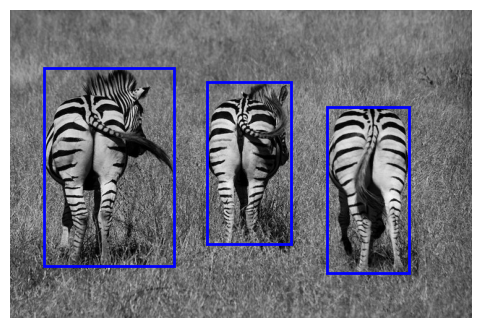

In [267]:
bboxes_filtered = nms(bboxes=bboxes, treshold=0.5, conf=confes)

fig, ax = plt.subplots(figsize=(14, 4))
ax.set_axis_off()
ax.imshow(img)

for bbox_idx in bboxes_filtered:
    x, y, w, h= bboxes[bbox_idx]
    rect = Rectangle(xy=(x - w/2, y - h/2), width=w, height=h, facecolor="none", edgecolor=colors.get(labels[bbox_idx]), linewidth=2)
    ax.add_patch(rect)